In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus as pp
import seaborn as sns

from collections import Counter

from IPython.display import display
from IPython.display import Image

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor

In [2]:
class CONFIG:
    INDEXS = ["R2", "EV", "ME", "MEAN_AE", "MSE", "MEDIAN_AE", "HIT@10", "HIT@100"]

# Load Dataset

In [3]:
header = pd.read_csv("Dataset/header.csv", header=None)
header

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable


In [4]:
training_dataset = pd.read_csv("Dataset/Training/Features_Variant_5.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])
training_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,0,0,0,0,0,1,0,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,0,1,0,0,0,0,0,0,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,0,0,1,0
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,1,0,0,0,0,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,0,0,0,0,0,1,0,0,0,203
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,0,0,0,0,0,1,0,0,0,42
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,0,0,0,0,0,1,0,0,0,51
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,0,0,0,0,0,0,1,0,0,17


In [5]:
training_labels = training_dataset.iloc[:, -1:]
training_labels

,Target Variable
0,0
1,0
2,0
3,0
4,0
...,...
199025,203
199026,42
199027,51
199028,17


In [6]:
test_dataset = pd.read_csv("Dataset/Testing/Features_TestSet.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])
test_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
0,634995,0,463,1,1.0,17.0,7.000000,2.0,6.663332,1.0,...,0,0,0,0,0,0,1,0,0,1
1,634995,0,463,1,1.0,17.0,7.000000,2.0,6.663332,1.0,...,0,0,0,0,0,0,0,1,0,0
2,634995,0,463,1,1.0,17.0,7.000000,2.0,6.663332,1.0,...,1,0,0,0,0,0,0,1,0,0
3,634995,0,463,1,1.0,17.0,7.000000,2.0,6.663332,1.0,...,0,1,1,0,0,0,0,0,0,0
4,634995,0,463,1,1.0,17.0,7.000000,2.0,6.663332,1.0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10039,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,0,0,1,0,0,0,0,0,1
10040,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,0,0,1,0,0,0,0,0,13
10041,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,0,1,0,0,0,0,0,0,1087
10042,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,0,0,1,0,0,0,0,0,14


In [7]:
test_labels = test_dataset.iloc[:, -1:]
test_labels

,Target Variable
0,1
1,0
2,0
3,0
4,1
...,...
10039,1
10040,13
10041,1087
10042,14


# Combine Dataset

In [8]:
n_training_dataset = training_dataset.shape[0]
n_test_dataset = test_dataset.shape[0]
dataset = pd.concat((training_dataset, test_dataset)).reset_index(drop=True)
dataset = dataset.drop(['Target Variable'], axis=1)
print("dataset size is : {}".format(dataset.shape))

dataset size is : (209074, 53)


# Data Preprocessing

## Log-Transformation of Target Variable

In [9]:
training_labels["Target Variable"] = np.log1p(training_labels["Target Variable"])

## Drop Features

In [10]:
dataset = dataset.drop(['Post Promotion Status'], axis=1)
dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Thursday,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,0,0,0,0,0,0,1,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,1,0,0,0,0,0,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,1,0,0,0,0,0,0,0,1
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,1,0,0,1,0,0,0,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209069,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,0,0,0,1,0,0,0,0,0
209070,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,0,0,0,1,0,0,0,0,0
209071,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,0,0,1,0,0,0,0,0,0
209072,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,0,0,0,1,0,0,0,0,0


## Add Related Features

In [11]:
post_published_weekday = (dataset["Post published weekday-Monday"]
                          + dataset["Post published weekday-Tuesday"]
                          + dataset["Post published weekday-Wednesday"]
                          + dataset["Post published weekday-Thursday"]
                          + dataset["Post published weekday-Friday"]).astype("int")
post_published_weekend = (dataset["Post published weekday-Sunday"]
                          + dataset["Post published weekday-Saturday"]).astype("int")
dataset.insert(46, "Post published weekday", post_published_weekday)
dataset.insert(47, "Post published weekend", post_published_weekend)

base_datetime_weekday = (dataset["Base DateTime weekday-Monday"]
                          + dataset["Base DateTime weekday-Tuesday"]
                          + dataset["Base DateTime weekday-Wednesday"]
                          + dataset["Base DateTime weekday-Thursday"]
                          + dataset["Base DateTime weekday-Friday"]).astype("int")
base_datetime_weekend = (dataset["Base DateTime weekday-Sunday"]
                          + dataset["Base DateTime weekday-Saturday"]).astype("int")

dataset.insert(48, "Base DateTime weekday", base_datetime_weekday)
dataset.insert(49, "Base DateTime weekend", base_datetime_weekend)
dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday,Post published weekend,Base DateTime weekday,Base DateTime weekend,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,1,0,0,0,0,1,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,1,0,0,0,0,0,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,1,0,0,0,0,0,1
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,1,0,1,0,0,0,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209069,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,1,1,0,1,0,0,0,0,0
209070,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,1,1,0,1,0,0,0,0,0
209071,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,1,0,1,0,0,0,0,0,0
209072,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,1,1,0,1,0,0,0,0,0


## Convert to Categorical Features

In [12]:
dataset['Post published weekday'] = dataset['Post published weekday'].apply(str)
dataset['Post published weekend'] = dataset['Post published weekend'].apply(str)
dataset['Base DateTime weekday'] = dataset['Base DateTime weekday'].apply(str)
dataset['Base DateTime weekend'] = dataset['Base DateTime weekend'].apply(str)

dataset['Post published weekday-Monday'] = dataset['Post published weekday-Monday'].apply(str)
dataset['Post published weekday-Tuesday'] = dataset['Post published weekday-Tuesday'].apply(str)
dataset['Post published weekday-Wednesday'] = dataset['Post published weekday-Wednesday'].apply(str)
dataset['Post published weekday-Thursday'] = dataset['Post published weekday-Thursday'].apply(str)
dataset['Post published weekday-Friday'] = dataset['Post published weekday-Friday'].apply(str)
dataset['Post published weekday-Saturday'] = dataset['Post published weekday-Saturday'].apply(str)
dataset['Post published weekday-Sunday'] = dataset['Post published weekday-Sunday'].apply(str)

dataset['Base DateTime weekday-Monday'] = dataset['Base DateTime weekday-Monday'].apply(str)
dataset['Base DateTime weekday-Tuesday'] = dataset['Base DateTime weekday-Tuesday'].apply(str)
dataset['Base DateTime weekday-Wednesday'] = dataset['Base DateTime weekday-Wednesday'].apply(str)
dataset['Base DateTime weekday-Thursday'] = dataset['Base DateTime weekday-Thursday'].apply(str)
dataset['Base DateTime weekday-Friday'] = dataset['Base DateTime weekday-Friday'].apply(str)
dataset['Base DateTime weekday-Saturday'] = dataset['Base DateTime weekday-Saturday'].apply(str)
dataset['Base DateTime weekday-Sunday'] = dataset['Base DateTime weekday-Sunday'].apply(str)

dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday,Post published weekend,Base DateTime weekday,Base DateTime weekend,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,1,0,0,0,0,1,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,1,0,0,0,0,0,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,1,0,0,0,0,0,1
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,1,0,1,0,0,0,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209069,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,1,1,0,1,0,0,0,0,0
209070,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,1,1,0,1,0,0,0,0,0
209071,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,1,0,1,0,0,0,0,0,0
209072,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,1,1,0,1,0,0,0,0,0


## Skewed Features

In [13]:
numeric_feats = dataset.dtypes[dataset.dtypes != "object"].index
numeric_feats

# Check the skew of all numerical features
skewed_feats = dataset[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
Derived15,212.937554
Post Share Count,101.546681
Derived10,92.904607
Derived5,58.308480
Derived20,56.155838
Page Popularity/likes,49.889082
Derived18,32.898468
Derived28,22.047806
Post length,19.431971
Derived13,18.384543


## Box Cox Transformation of Highly Skewed Features

In [14]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    dataset[feat] = boxcox1p(dataset[feat], lam)

dataset

There are 38 skewed numerical features to Box Cox transform


,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday,Post published weekend,Base DateTime weekday,Base DateTime weekend,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday
0,42.801338,0.000000,10.078383,0.730463,0.0,12.833625,3.254497,0.730463,6.553749,0.0,...,1,0,1,0,0,0,0,1,0,0
1,42.801338,0.000000,10.078383,0.730463,0.0,12.833625,3.254497,0.730463,6.553749,0.0,...,1,0,0,1,0,0,0,0,0,0
2,42.801338,0.000000,10.078383,0.730463,0.0,12.833625,3.254497,0.730463,6.553749,0.0,...,1,0,0,1,0,0,0,0,0,1
3,42.801338,0.000000,10.078383,0.730463,0.0,12.833625,3.254497,0.730463,6.553749,0.0,...,1,0,1,0,1,0,0,0,0,0
4,42.801338,0.000000,10.078383,0.730463,0.0,12.833625,3.254497,0.730463,6.553749,0.0,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209069,64.493611,5.968981,41.016197,2.750250,0.0,14.278491,10.182672,9.064718,10.328218,0.0,...,0,1,1,0,1,0,0,0,0,0
209070,64.493611,5.968981,41.016197,2.750250,0.0,14.278491,10.182672,9.064718,10.328218,0.0,...,0,1,1,0,1,0,0,0,0,0
209071,64.493611,5.968981,41.016197,2.750250,0.0,14.278491,10.182672,9.064718,10.328218,0.0,...,0,1,0,1,0,0,0,0,0,0
209072,64.493611,5.968981,41.016197,2.750250,0.0,14.278491,10.182672,9.064718,10.328218,0.0,...,0,1,1,0,1,0,0,0,0,0


## One Hot Encoding

In [15]:
dataset = pd.get_dummies(dataset)
dataset.shape

(209074, 74)

# Split Dataset

In [16]:
training_dataset = dataset[:n_training_dataset]
test_dataset = dataset[n_training_dataset:]

In [17]:
training_dataset.shape

(199030, 74)

In [18]:
test_dataset.shape

(10044, 74)

In [19]:
training_features = training_dataset
training_features

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Base DateTime weekday-Tuesday_0,Base DateTime weekday-Tuesday_1,Base DateTime weekday-Wednesday_0,Base DateTime weekday-Wednesday_1,Base DateTime weekday-Thursday_0,Base DateTime weekday-Thursday_1,Base DateTime weekday-Friday_0,Base DateTime weekday-Friday_1,Base DateTime weekday-Saturday_0,Base DateTime weekday-Saturday_1
0,42.801338,0.000000,10.078383,0.730463,0.0,12.833625,3.254497,0.730463,6.553749,0.0,...,1,0,1,0,0,1,1,0,1,0
1,42.801338,0.000000,10.078383,0.730463,0.0,12.833625,3.254497,0.730463,6.553749,0.0,...,1,0,1,0,1,0,1,0,1,0
2,42.801338,0.000000,10.078383,0.730463,0.0,12.833625,3.254497,0.730463,6.553749,0.0,...,1,0,1,0,1,0,1,0,0,1
3,42.801338,0.000000,10.078383,0.730463,0.0,12.833625,3.254497,0.730463,6.553749,0.0,...,1,0,1,0,1,0,1,0,1,0
4,42.801338,0.000000,10.078383,0.730463,0.0,12.833625,3.254497,0.730463,6.553749,0.0,...,1,0,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,64.493611,5.968981,41.016197,2.750250,0.0,14.430660,10.099824,8.548743,10.261870,0.0,...,1,0,0,1,1,0,1,0,1,0
199026,64.493611,5.968981,41.016197,2.750250,0.0,14.430660,10.099824,8.548743,10.261870,0.0,...,1,0,0,1,1,0,1,0,1,0
199027,64.493611,5.968981,41.016197,2.750250,0.0,14.430660,10.099824,8.548743,10.261870,0.0,...,1,0,0,1,1,0,1,0,1,0
199028,64.493611,5.968981,41.016197,2.750250,0.0,14.430660,10.099824,8.548743,10.261870,0.0,...,1,0,1,0,0,1,1,0,1,0


In [20]:
test_features = test_dataset
test_features

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Base DateTime weekday-Tuesday_0,Base DateTime weekday-Tuesday_1,Base DateTime weekday-Wednesday_0,Base DateTime weekday-Wednesday_1,Base DateTime weekday-Thursday_0,Base DateTime weekday-Thursday_1,Base DateTime weekday-Friday_0,Base DateTime weekday-Friday_1,Base DateTime weekday-Saturday_0,Base DateTime weekday-Saturday_1
199030,42.801338,0.000000,10.078383,0.730463,0.730463,3.618223,2.440268,1.194318,2.381725,0.730463,...,1,0,1,0,0,1,1,0,1,0
199031,42.801338,0.000000,10.078383,0.730463,0.730463,3.618223,2.440268,1.194318,2.381725,0.730463,...,1,0,1,0,1,0,0,1,1,0
199032,42.801338,0.000000,10.078383,0.730463,0.730463,3.618223,2.440268,1.194318,2.381725,0.730463,...,1,0,1,0,1,0,0,1,1,0
199033,42.801338,0.000000,10.078383,0.730463,0.730463,3.618223,2.440268,1.194318,2.381725,0.730463,...,1,0,1,0,1,0,1,0,1,0
199034,42.801338,0.000000,10.078383,0.730463,0.730463,3.618223,2.440268,1.194318,2.381725,0.730463,...,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209069,64.493611,5.968981,41.016197,2.750250,0.000000,14.278491,10.182672,9.064718,10.328218,0.000000,...,1,0,1,0,1,0,1,0,1,0
209070,64.493611,5.968981,41.016197,2.750250,0.000000,14.278491,10.182672,9.064718,10.328218,0.000000,...,1,0,1,0,1,0,1,0,1,0
209071,64.493611,5.968981,41.016197,2.750250,0.000000,14.278491,10.182672,9.064718,10.328218,0.000000,...,1,0,1,0,1,0,1,0,1,0
209072,64.493611,5.968981,41.016197,2.750250,0.000000,14.278491,10.182672,9.064718,10.328218,0.000000,...,1,0,1,0,1,0,1,0,1,0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels, test_size=.3, random_state=42)

# LightGBM

## Model Training

In [22]:
def create_model():
    # LGBMRegressor
    model = LGBMRegressor(
        max_depth=12,
        n_estimators=720,
        random_state=42,
    )
    return model

In [23]:
def train_model(model):
    model.fit(X_train, y_train.values.ravel())
    return model

In [24]:
def predict(model, X):
    pred = model.predict(X)
    return pred

In [25]:
def plot_test_predict(y_test, predict, axes=None, k=None):
    test_predict = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(predict.transpose())], axis=1)
    headers = ["Test", "Predict"]
    test_predict.columns = headers
    if axes is not None and k is not None:
        sns.lineplot(data=test_predict.sample(n=200), ax=axes[k]).set_title("Test Predict Curve k = " + str(k))
    else:
        sns.lineplot(data=test_predict.sample(n=200)).set_title("Test Predict Curve")
    plt.show()
    sns.residplot(x=predict, y=y_test.to_numpy(), lowess=True).set_title("Residuals")
    plt.show()
    y_test_np = y_test.to_numpy().flatten()
    sns.residplot(x=predict, y=y_test_np * (predict - y_test_np), lowess=True).set_title("Residuals")
    plt.show()

## Model Evaluation

In [26]:
def evaluate(model, y_test, predict):

    # R-Squared
    r2 = r2_score(y_test, predict)
    
    # Explained Variance Score
    ev = explained_variance_score(y_test, predict)
    
    # Max Error
    me = max_error(y_test, predict)
    
    # Mean Absolute Error
    mean_ae = mean_absolute_error(y_test, predict)
    
    # Mean Squared Error
    mse = mean_squared_error(y_test, predict)
    
    # Median Absolute Error
    median_ae = median_absolute_error(y_test, predict)
    
    # Hit@10
    y_test_np = y_test.to_numpy().flatten()
    hit = np.abs(y_test_np - predict) < 10
    hit_10 = np.sum(hit) / hit.shape[0]
    
    # Hit@100
    y_test_np = y_test.to_numpy().flatten()
    ordered_y_test = np.argsort(y_test_np)
    max_y_test = ordered_y_test[-100:]
    ordered_predict = np.argsort(predict)
    max_predict = ordered_predict[-100:]
    acc = 0
    for pred in max_predict:
        if pred in max_y_test:
            acc += 1
    hit_100 = acc / 100
    
    return r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100

## Final Model

In [27]:
def train_final_model():
    
    model = create_model()

    # Model Training
    model = train_model(model)
    pred = predict(model, X_test)
    plot_test_predict(np.expm1(y_test), np.expm1(pred))

    # Model Evaluation
    r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100 = evaluate(model, np.expm1(y_test), np.expm1(pred))

    results = pd.DataFrame({
        "Index": CONFIG.INDEXS, 
        "Mean": [r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100]
    })
    print(results)
    
    return model

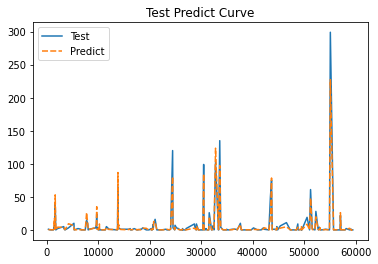

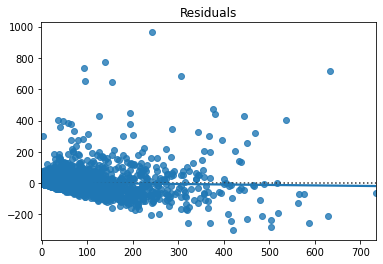

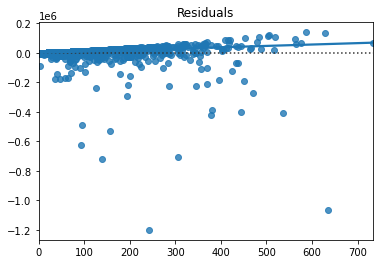

       Index        Mean
0         R2    0.751497
1         EV    0.752517
2         ME  992.696007
3    MEAN_AE    2.960502
4        MSE  254.994508
5  MEDIAN_AE    0.360126
6     HIT@10    0.945720
7    HIT@100    0.630000


In [28]:
model = train_final_model()

# Model Testing

In [29]:
def test():
    pred = predict(model, test_features)
    plot_test_predict(test_labels, np.expm1(pred))

    # Model Evaluation
    r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100 = evaluate(model, test_labels, np.expm1(pred))

    results = pd.DataFrame({
        "Index": CONFIG.INDEXS, 
        "Mean": [r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100]
    })
    print(results)

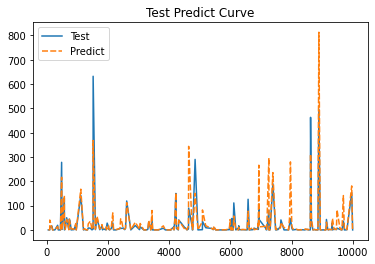

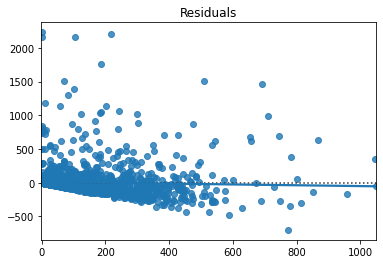

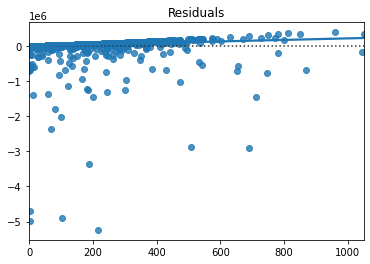

       Index         Mean
0         R2     0.396669
1         EV     0.396713
2         ME  2232.446286
3    MEAN_AE    20.611985
4        MSE  7982.898100
5  MEDIAN_AE     1.963940
6     HIT@10     0.752190
7    HIT@100     0.320000


In [30]:
test()